(poly-interpol)=
# Polynomial interpolation

## Introduction
Polynomials can be used to approximate functions over some bounded
interval $x \in [a,b]$. Such polynomials can be used for different purposes.
The function itself may be unknown, and only measured data are available. In
this case, a polynomial may be used to find approximations to intermediate
values of the function. Polynomials are
easy to integrate, and can be used to find approximations of integrals of more complicated
functions. This will be exploited later in the course. And there are plenty of other applications.

Let's consider the following problem. The estimated mean atmospheric concentration of carbon dioxide in the earth's atmosphere
is given in the following table.

|    year       |   CO2 (ppm)    |
| :------------ | :------------- |
|     1800      |      280       |
|     1850      |      283       |
|     1900      |      291       |
|     2000      |      370       |

Is there a simple method to estimate the $\mathrm{CO}_2$ concentration on (a) 1950 and (b) 2050?

This is where **interpolation polynomials** comes into play!

::::{prf:definition} Interpolation problem

Given $n+1$ points $(x_i,y_i)_{i=0}^n$, find a polynomial $p(x)$ of
lowest possible degree satisfying the **interpolation condition**

:::{math}
:label: interpol-condition 
    p(x_i) = y_i,\qquad i=0,\dotsc, n. 
:::

The solution $p(x)$ is called the **interpolation polynomial**, the $x_i$ values
are called **nodes**, and the points $(x_i,y_i)$ **interpolation points**.
::::

:::{prf:example}
:label: ex-interpol-I

Given are the points

$$
\begin{array}{c|c|c|c}
x_i & 0 & 2/3 & 1 \\ \hline
y_i & 1 & 1/2 & 0 
\end{array}.
$$

The corresponding interpolation polynomial is

$$
p_2(x)=(-3x^2-x+4)/4
$$

The $y$-values of this example are chosen such that $y_i=\cos{(\pi x_i/2)}$.  So
$p_2(x)$ can be considered as an approximation to $\cos{(\pi x/2)}$ on the interval
$[0,1]$.

:::

To visualize this, we need to import some modules first, using the following boilerplate code.

In [2]:
#%matplotlib widget
import numpy as np
from numpy import pi
from numpy.linalg import solve, norm    # Solve linear systems and compute norms
import matplotlib.pyplot as plt

newparams = {'figure.figsize': (6.0, 6.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

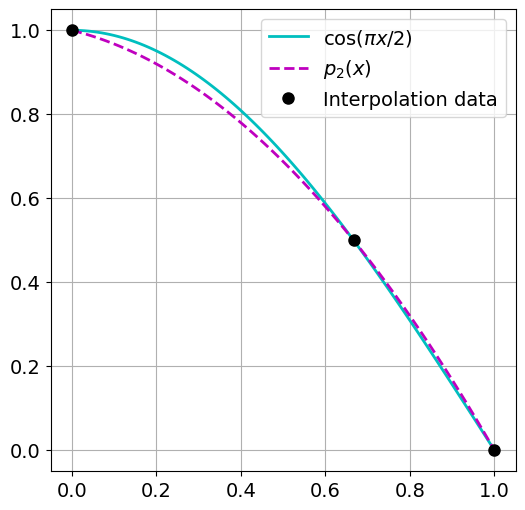

In [3]:
# Interpolation data
xdata = [0,2/3., 1]
ydata = [1, 1/2., 0]

# Interpolation polynomial
p2 = lambda x : (-3*x**2 -x + 4)/4.

# Grid points for plotting
x = np.linspace(0,1,100)
y = p2(x)

# Original function
f = np.cos(pi*x/2)

plt.figure()
plt.plot(x,f, 'c',x,y,'--m', xdata, ydata, "ok")
plt.legend([r'$\cos(\pi x/2)$', r'$p_2(x)$', 'Interpolation data'])

**Content of this module**

In this module, we will discuss the following:

* Method: How to compute the polynomials?

* Existence and uniqueness results. 

* Error analysis: If the polynomial is used to approximate a function, how good is the approximation?

* Improvements: If the nodes $x_i$ can be chosen freely, how should we do it in order to reduce the error?

## Preliminaries

Let us start with some useful notation and facts about polynomials.  
* A polynomial of degree $n$ is given by

\begin{equation} 
 p_n(x) = c_{n}x^n + c_{n-1}x^{n-1} + \cdots + c_1 x_1 + c_0, \qquad  c_i \in
\mathbb{R}, \quad i=0,1,\dotsc,n.
\end{equation}

* $\mathbb{P}_n$ is the set of all polynomials of degree $n$.

* $C^m[a,b]$ is the set of all continuous functions that have continuous first $m$ derivatives.

* The value $r$ is a root or a zero of a polynomial $p$ if $p(r)=0$.  

* A nonzero polynomial of degree $n$ can never have more than $n$ real roots (there may be less).  
* A polynomial of degree $n$ with $n$ real roots $r_1,r_2,\dotsc,r_n$can be written as

$$
p_n(x) = c(x-r_1)(x-r_2)\dotsm(x-r_n) = c\prod_{i=1}^n(x-r_i).
$$

## The direct approach
For a polynomial of degree $n$ the interpolation condition {eq}`interpol-condition` is a linear systems of 
$n+1$ equations in $n+1$ unknowns:

$$
\sum_{i=0}^n x_j^i c_i = y_j, \qquad j=0,\dotsc, n.
$$

In other words, we try to solve the linear system

:::{math}
:label: eq-vandermonde-sys

\underbrace{
\begin{pmatrix}
1 & x_0 & x_0^2 & \cdots & x_0^n
\\
1 & x_1 & x_1^2 & \cdots & x_1^n
\\
\vdots & \vdots & \vdots & \ddots & \vdots
\\
1 & x_n & x_n^2 & \cdots & x_n^n
\end{pmatrix}
}_{:= V(x_0, x_1, \ldots, x_n)}
\begin{pmatrix}
c_0
\\
c_1
\\
\vdots
\\
c_n
\end{pmatrix}
= 
\begin{pmatrix}
y_0
\\
y_1
\\
\vdots
\\
y_n
\end{pmatrix}.

:::

$V(x_0, x_1, \ldots, x_n)$ denotes the so-called [Vandermonde matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix).
It can be shown that 

$$
\det V(x_0, x_1, \ldots, x_n) = \prod_{0\leqslant i < j \leqslant n} (x_j - x_i)
$$

Consequently, $\det V \neq 0$ for $n$ *distinct* nodes $\{x_i\}_{i=0}^n$ and thus {eq}`eq-vandermonde-sys` is uniquely solvable.

If we are basically interested in the polynomials themself, given by the coefficients $c_i$, $i=0,1,\dotsc, n$, this is a perfectly fine solution. It is for instance the strategy implemented in MATLAB's interpolation routines. However, in this course, polynomial interpolation will be used as a basic tool to construct other algorithms, in particular for integration. In that case, this is not the most convenient option, so we concentrate on a different strategy, which essentially makes it possible to just write up the polynomials.

(lagrange-interpol)=
## Lagrange interpolation

:::{prf:definition}
:label: def-lagrange-polys

Given $n+1$ points  $(x_i,y_i)_{i=0}^n$ with distinct $x_i$ values. 
The **cardinal functions** are defined by

$$
\ell_i(x) = \prod_{j=0,j\not=i}^n \frac{x-x_j}{x_i-x_j}
  = \frac{x-x_0}{x_i-x_0} \dotsm \frac{x-x_{i-1}}{x_i-x_{i-1}}\cdot \frac{x-x_{i+1}}{x_i-x_{i+1}} \dotsm \frac{x-x_n}{x_i-x_n} , \qquad i=0,\dotsc,n.
$$
:::

:::{prf:observation}
:label: my-observation

The cardinal functions have the following properties:
* $\ell_i \in \mathbb{P}_n$, $i=0,1,\dotsc,n$.

* $\ell_i(x_j) = \delta_{ij} = \begin{cases} 1, & \text{when } i=j \\ 0, & \text{when }i\not=j \end{cases}$.

* They are constructed solely from the nodes $x_i$'s.

* They are linearly independent, and thus form a basis for $\mathbb{P}_{n}$.

:::

:::{prf:remark} 

The cardinal functions are also often called  **Lagrange polynomials**.
:::

The interpolation polynomial is now given by

$$
p_n(x) = \sum_{i=0}^n y_i \ell_i(x)
$$

since

$$
p_n(x_j) = \sum_{i=0}^n y_i \ell_i(x_j) = y_j, \qquad j=0,\dotsc,n.
$$

:::{prf:example}
:label: exam-interpol-I
Given the points:

$$
\begin{array}{c|ccc}
x_i & 0 & 1 & 3 \\ \hline y_i & 3 & 8 & 6
\end{array}.
$$

The corresponding cardinal functions are given by:

\begin{align*}
  \ell_0(x) & = \frac{(x-1)(x-3)}{(0-1)(0-3)}
           = \frac{1}{3}x^2-\frac{4}{3}x+1 \\ 
  \ell_1(x) & = \frac{(x-0)(x-3)}{(1-0)(1-3)}
           = -\frac12 x^2 + \frac32 x \\ 
  \ell_2(x) &= \frac{(x-0)(x-1)}{(3-0)(3-1)} = \frac16 x^2-\frac16 x
\end{align*}

and the interpolation polynomial is given by (check it yourself):

$$
p_2(x) = 3 \ell_0(x) + 8 \ell_1(x) + 6 \ell_2(x) = -2x^2 + 7x + 3.
$$

:::

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
plt.rcParams['figure.figsize'] = [10, 5]
import scipy.interpolate as ip

def plot_lagrange_basis(a, b, N):
    """ Plot the Lagrange nodal functions for given nodal points."""
    xi = np.linspace(a,b,N)
    N = xi.shape[0]
    nodal_values = np.ma.identity(N)

    # Create finer grid to print resulting functions
    xn = np.linspace(xi[0],xi[-1],100)
    fig = plt.figure()

    for i in range(N):
        L = ip.lagrange(xi, nodal_values[i])
        line, = plt.plot(xn, L(xn), "-", label=(r"$\ell_{%d}$"%i))
        plt.plot(xi, L(xi), "o", color=line.get_color())

    plt.legend() 
    plt.title("Lagrange basis for order %d" % (N-1))
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\ell_i(x)$")
    plt.show()

In [ ]:
a, b = 0, 3
N = 3
plot_lagrange_basis(a, b, N)

In [ ]:
# Define a helper function to be connected with the slider
a, b = 0, 3
plp = lambda N : plot_lagrange_basis(a, b, N)
slider = widgets.IntSlider(min = 2,
                           max = 10,
                           step = 1,
                           description="Number of interpolation points N",
                           value = 3)
interact(plp, N=slider)

## Implementation
The method above is implemented as two functions:
* `cardinal(xdata, x)`: Create a list of cardinal functions $\ell_i(x)$ evaluated in $x$.

* `lagrange(ydata, l)`: Create the interpolation polynomial $p_n(x)$.

Here, `xdata` and `ydata` are arrays with the interpolation points, and `x` is an 
array of values in which the polynomials are evaluated. 

You are not required to understand the implementation of these functions, but you should understand how to use them.

In [ ]:
from math import factorial
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

In [ ]:
def cardinal(xdata, x):
    """
    cardinal(xdata, x): 
    In: xdata, array with the nodes x_i.
        x, array or a scalar of values in which the cardinal functions are evaluated.
    Return: l: a list of arrays of the cardinal functions evaluated in x. 
    """
    n = len(xdata)              # Number of evaluation points x
    l = []
    for i in range(n):          # Loop over the cardinal functions
        li = np.ones(len(x))
        for j in range(n):      # Loop to make the product for l_i
            if i is not j:
                li = li*(x-xdata[j])/(xdata[i]-xdata[j])
        l.append(li)            # Append the array to the list            
    return l

def lagrange(ydata, l):
    """
    lagrange(ydata, l):
    In: ydata, array of the y-values of the interpolation points.
         l, a list of the cardinal functions, given by cardinal(xdata, x)
    Return: An array with the interpolation polynomial. 
    """
    poly = 0                        
    for i in range(len(ydata)):
        poly = poly + ydata[i]*l[i]  
    return poly

:::{exercise}

1. Let's test the functions on the interpolation points of {prf:ref}`exam-interpol-I`.
and the resulting interpolation polynomial.

2. Redo the exercise for some points of your own choice.

:::

In [ ]:
# Insert your code here 
xdata = [0, 1, 3]           # The interpolation points
ydata = [3, 8, 6]
x = np.linspace(0, 3, 101)     # The x-values in which the polynomial is evaluated
l = cardinal(xdata, x)      # Find the cardinal functions evaluated in x
p = lagrange(ydata, l)      # Compute the polynomial evaluated in x
plt.plot(x, p)                  # Plot the polynomial
plt.plot(xdata, ydata, 'o')     # Plot the interpolation points 
plt.title('The interpolation polynomial p(x)')
plt.xlabel('x');

## Existence and uniqueness of interpolation polynomials.
We have already proved the existence of such polynomials, simply by constructing
them. But are they unique? The answer is yes!

:::{prf:theorem} Existence and uniqueness of the interpolation polynomial
Given $n+1$ points $(x_i,y_i)_{i=0}^n$ with $n+1$ distinct $x$ values. Then there is
one and only one polynomial $p_n(x) \in \mathbb{P}_n$ satisfying the
interpolation condition

$$
p_n(x_i) = y_i, \qquad i=0,\dotsc, n.
$$
:::

:::{prf:proof}
Suppose there exist two different interpolation polynomials $p_n$ and
$q_n$ of degree $n$ interpolating the same $n+1$ points. The
polynomial $r(x) = p_n(x)-q_n(x)$ is of degree $n$ with zeros in all
the nodes $x_i$, that is a total of $n+1$ zeros. But then $r\equiv 0$,
and the two polynomials $p_n$ and $q_n$ are identical.
:::